In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## all the required libraries for the given data
import os
import pandas as pd
import numpy as np
import json
import re
import ast
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## to change directory
os.chdir('/content/drive/My Drive/factset')

In [5]:
ls

 logi.pickle          'Untitled0 (1).ipynb'   your_file_name.png
 movies_metadata.csv   xgb.pickle


In [0]:
## load the data
data= pd.read_csv('movies_metadata.csv')

In [7]:
## first 5 records of the data
data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [8]:
## columns present in the data
data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

## As per the target column few independent columns are sufficient. Now we'll create a new dataframe with the requried columns.

In [0]:
## creating a new data frame with the requried columns
movies=pd.DataFrame(data[['title','original_title','tagline','overview','genres']])

In [8]:
movies.head()

,title,original_title,tagline,overview,genres
0,Toy Story,Toy Story,NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,Jumanji,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,Grumpier Old Men,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,Waiting to Exhale,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,Father of the Bride Part II,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


In [11]:
## to check number of missing values in the data
movies.isnull().sum()

title                 6
original_title        0
tagline           25054
overview            954
genres                0
dtype: int64

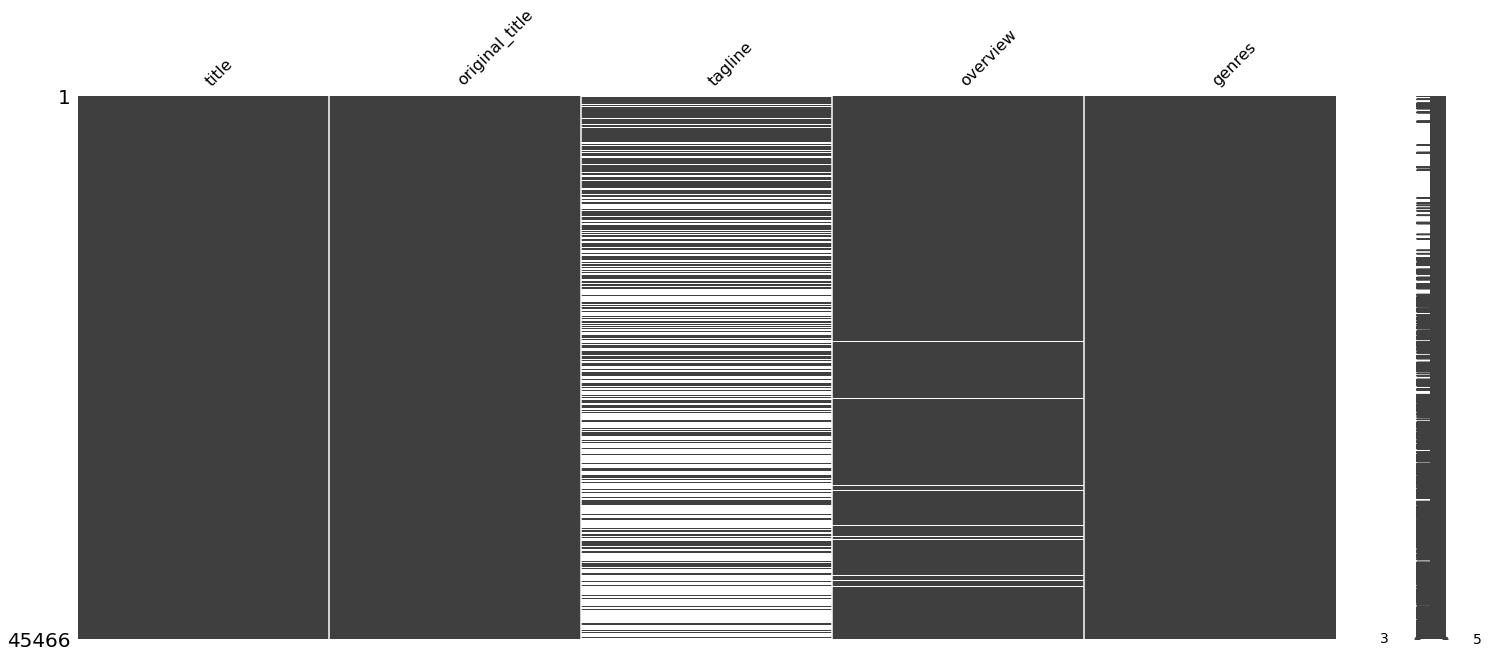

In [12]:
## using visualizations check the missing values
import missingno as msno 
msno.matrix(movies)

In [9]:
## shape of the data
movies.shape

(45466, 5)

## as we can see that the genre column is in JSON format. So to further process we need to convert to list by extracting genre names.

In [9]:
## extracting genres names from genre column by using below function and create a new column to it
movies['new_genres']=''
for a in range(0,movies.shape[0]):
    dict=[]
    for i in range(0,len(movies.genres[a])):
        if movies.genres[a][i] == 'n' and movies.genres[a][i+1]=='a' and movies.genres[a][i+2] == 'm':
            str1=movies.genres[a][i+8:len(movies.genres)-1].split('}')[0]
            str1=str1[0:len(str1)-1]
            print(str1)
            dict.append(str1)
            movies["new_genres"][a]=dict

Streaming output truncated to the last 5000 lines.
Drama
Horror
Thriller
Horror
Documentary
Thriller
Horror
Mystery
Crime
Horror
Thriller
Thriller
Romance
Comedy
Romance
Drama
Drama
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Music
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Comedy
Drama
Crime
Drama
Thriller
Action
Comedy
Action
Animation
Romance
Drama
Horror
Thriller
Action
Animation
Horror
Science Fiction
Drama
Drama
Thriller
Crime
Mystery
Drama
TV Movie
Animation
Comedy
Drama
Thriller
Horror
Drama
War
Adventure
Drama
Romance
Documentary
Drama
Drama
Drama
TV Movie
Drama
Documentary
Drama
Horror
Fantasy
Horror
Action
Foreign
Thriller
Action
Adventure
Horror
Comedy
Action
Science Fiction
Action
Crime
Thriller
Action
Thriller
Foreign
Romance
Drama
Horror
Action
Horror
Action
Drama
Comedy
Fantasy
Horror
Romance
A

In [60]:
movies.head()

,title,original_title,tagline,overview,genres,new_genres
0,Toy Story,Toy Story,NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[Animation, Comedy, Family]"
1,Jumanji,Jumanji,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,Grumpier Old Men,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[Romance, Comedy]"
3,Waiting to Exhale,Waiting to Exhale,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,Father of the Bride Part II,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",[Comedy]


## after creating the new column check the word frequency of the new genre column with the help of word cloud

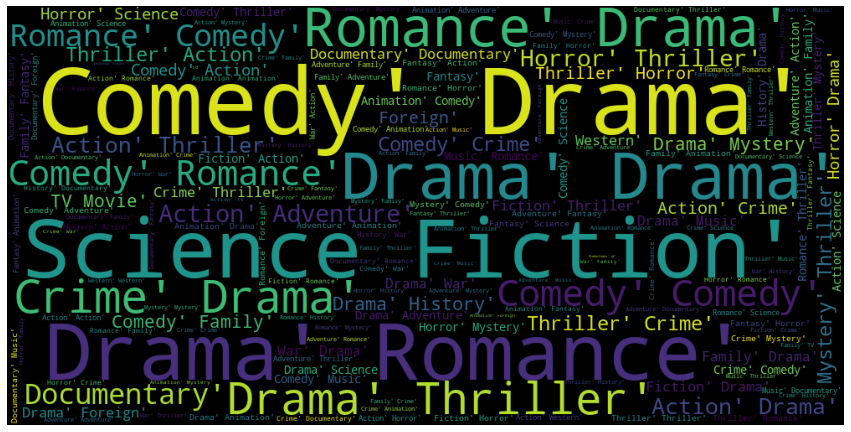

In [63]:
## creating a word cloud for genres
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

#convert list to string and generate
M= movies['new_genres'].astype(str)
unique_string=(" ").join(M)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()


## As there are only few na values present in the title and overview we can remove those records.

In [0]:
## droping the na records present in overview and title
movies= movies.dropna(subset=['overview','title'])

In [0]:
## combining all the other independent variable columns to one variable for text processing
movies['total_overview']= movies['title'].astype(str)+' '+movies['overview'].astype(str)+' '+movies['original_title'].astype(str)

In [66]:
movies.head()

,title,original_title,tagline,overview,genres,new_genres,total_overview
0,Toy Story,Toy Story,NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[Animation, Comedy, Family]","Toy Story Led by Woody, Andy's toys live happi..."
1,Jumanji,Jumanji,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[Adventure, Fantasy, Family]",Jumanji When siblings Judy and Peter discover ...
2,Grumpier Old Men,Grumpier Old Men,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[Romance, Comedy]",Grumpier Old Men A family wedding reignites th...
3,Waiting to Exhale,Waiting to Exhale,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[Comedy, Drama, Romance]","Waiting to Exhale Cheated on, mistreated and s..."
4,Father of the Bride Part II,Father of the Bride Part II,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",[Comedy],Father of the Bride Part II Just when George B...


## after combining the required columns we can drop the other columns 

In [0]:
## dropping the unnecessary columns
movies= movies.drop(['tagline','original_title','overview','genres'],axis=1)

In [13]:
movies.head()

,title,new_genres,total_overview
0,Toy Story,"[Animation, Comedy, Family]","Toy Story Led by Woody, Andy's toys live happi..."
1,Jumanji,"[Adventure, Fantasy, Family]",Jumanji When siblings Judy and Peter discover ...
2,Grumpier Old Men,"[Romance, Comedy]",Grumpier Old Men A family wedding reignites th...
3,Waiting to Exhale,"[Comedy, Drama, Romance]","Waiting to Exhale Cheated on, mistreated and s..."
4,Father of the Bride Part II,[Comedy],Father of the Bride Part II Just when George B...


In [14]:
## downloading the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Now, we convert the raw text to clean text with the help of tokenization and stemming and also by removing the stopwords

In [0]:
## function to convert the raw text
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
stemmer= SnowballStemmer('english')
def process(doc):
    stop= stopwords.words("english")
    x= word_tokenize(doc,language='english', preserve_line=True)
    stem= [stemmer.stem(word) for word in x]
    clean= [word for word in stem if not word in stop]
    joined= ' '.join(clean)
    return joined

In [0]:
## converting the raw text to clean text by using lambda function
movies['total_overview'] = movies['total_overview'].apply(lambda x: process(x))

In [0]:
# function for text cleaning 
def text_cleaner(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    
    text = re.sub("[^a-zA-Z]"," ",text)
    text= re.sub('s','',text)
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [0]:
movies['total_overview'] = movies['total_overview'].apply(lambda x: text_cleaner(x))

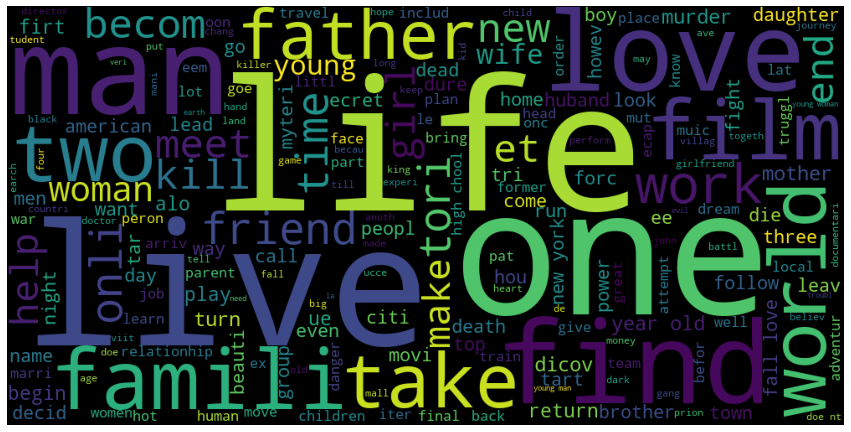

In [74]:
## creating a word cloud for total overview
T= movies['total_overview'].astype(str)
text_string=(" ").join(T)
wordcloud_text = WordCloud(width = 1000, height = 500).generate(text_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_text)
plt.axis("off")
plt.show()
plt.close()

## as there are 4000 unique list of genres we are using multilabel binarizer to create a multilabel format.

In [0]:
## by using multilabel binarzier we are transforming the new genres column
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies['new_genres'])

# transform target variable
y = multilabel_binarizer.transform(movies['new_genres'])

In [0]:
## creating tfidf vectorizer by using ngram parameter
tfidf = TfidfVectorizer(ngram_range=(1,2))

In [0]:
x= movies.total_overview

In [0]:
## using train test split split the data into 80:20 ratio
x_train,x_validation,y_train,y_validation= train_test_split(x,y,test_size=0.2,random_state=12)


In [0]:
# create TF-IDF features
x_train_tfidf = tfidf.fit_transform(x_train)
x_valid_tfidf = tfidf.transform(x_validation)

## with the help of OneVsRestClassifier classify multi label problem by implementing with other machine learning algorithms

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score

In [0]:
lr = LogisticRegression(random_state=10)
clf = OneVsRestClassifier(lr)

In [0]:
## fit the train data to the model
clf.fit(x_train_tfidf, y_train)

In [0]:
## predict the y variable with help of x variable
y_pred_train1=clf.predict(x_train_tfidf)
y_pred_valid1= clf.predict(x_valid_tfidf)

In [40]:
## find f1 score for both train and validation data
print(f1_score(y_train,y_pred_train1,average='micro'))
print(f1_score(y_validation,y_pred_valid1,average='micro'))

0.521674560488079
0.4353497597070715


In [0]:
def predict_genre(a):
    a = process(a)
    a = text_cleaner(a)
    a_vec = tfidf.transform([a])
    a_pred = clf.predict(a_vec)
    return multilabel_binarizer.inverse_transform(a_pred)

In [51]:
for i in range(5): 
  k = x_validation.sample(1).index[0] 
  print("Movie: ", movies['title'][k], "\nPredicted genre: ", predict_genre(x_validation[k])), print("Actual genre: ",movies['new_genres'][k], "\n")


Movie:  Ten 
Predicted genre:  [()]
Actual genre:  ['Drama'] 

Movie:  Just Friends 
Predicted genre:  [('Comedy', 'Drama')]
Actual genre:  ['Comedy', 'Romance'] 

Movie:  Salvador (Puig Antich) 
Predicted genre:  [()]
Actual genre:  ['Drama', 'History'] 

Movie:  Adventures in the Sin Bin 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Comedy'] 

Movie:  Private Resort 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Comedy'] 



## As we can see that it could predict atleast 3 movie genre out of 5

## DecisionTree Classifier with parameter tuning

In [41]:
from sklearn.tree import DecisionTreeClassifier
dec= DecisionTreeClassifier(random_state=11,max_features=30000)
clf_dec = OneVsRestClassifier(dec)
clf_dec.fit(x_train_tfidf,y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=30000,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=11,
                                        

In [0]:
y_pred_train2= clf_dec.predict(x_train_tfidf)
y_pred_valid2= clf_dec.predict(x_valid_tfidf)

In [43]:
print(f1_score(y_train,y_pred_train2,average='micro'))
print(f1_score(y_validation,y_pred_valid2,average='micro'))

0.9998956253087751
0.3994154895275207


In [58]:
from sklearn.tree import DecisionTreeClassifier
dec2= DecisionTreeClassifier(random_state=11,max_features=30000,max_depth=16)
clf_dec2 = OneVsRestClassifier(dec2)
clf_dec2.fit(x_train_tfidf,y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=16,
                                                     max_features=30000,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=11,
                                          

In [0]:
y_pred_train3= clf_dec2.predict(x_train_tfidf)
y_pred_valid3= clf_dec2.predict(x_valid_tfidf)

In [60]:
print(f1_score(y_train,y_pred_train3,average='micro'))
print(f1_score(y_validation,y_pred_valid3,average='micro'))

0.33962629281613527
0.26303703394430294


In [0]:
def predict_genre_dec(a):
    a = process(a)
    a = text_cleaner(a)
    a_vec = tfidf.transform([a])
    a_pred = clf_dec2.predict(a_vec)
    return multilabel_binarizer.inverse_transform(a_pred)

In [62]:
for i in range(5): 
  k = x_validation.sample(1).index[0] 
  print("Movie: ", movies['title'][k], "\nPredicted genre: ", predict_genre_dec(x_validation[k])), print("Actual genre: ",movies['new_genres'][k], "\n")


Movie:  Eloise at Christmastime 
Predicted genre:  [()]
Actual genre:  ['Family', 'Comedy', 'Drama'] 

Movie:  Ghoulies III: Ghoulies Go to College 
Predicted genre:  [('Horror',)]
Actual genre:  ['Fantasy', 'Drama', 'Horror', 'Action', 'Comedy'] 

Movie:  A Report on the Party and the Guests 
Predicted genre:  [()]
Actual genre:  ['Drama'] 

Movie:  Secret Window 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Mystery'] 

Movie:  Rosewood Lane 
Predicted genre:  [('Drama',)]
Actual genre:  ['Horror', 'Thriller'] 



## From the above we can say that logistic regression works good than the decision tree classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
random= RandomForestClassifier(n_estimators=1000,random_state=1)
clf_ran= OneVsRestClassifier(random)
clf_ran.fit(x_train_tfidf,y_train)

In [0]:
y_pred_train_ran= clf_ran.predict(x_train_tfidf)
y_pred_valid_ran= clf_ran.predict(x_valid_tfidf)

In [0]:
print(f1_score(y_train,y_pred_train_ran))
print(f1_score(y_validation,y_pred_valid_ran))

In [0]:
from sklearn.svm import SVC
svc= SVC(kernel='sigmoid',random_state=12)
clf_svc= OneVsRestClassifier(svc)
clf_svc.fit(x_train_tfidf,y_train)

In [0]:
y_pred_train_svc= clf_svc.predict(x_train_tfidf)
y_pred_valid_svc= clf_svc.predict(x_valid_tfidf)

In [0]:
print(f1_score(y_train,y_pred_train_svc))
print(f1_score(y_validation,y_pred_valid_svc))

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [0]:
xgb = XGBClassifier(learning_rate=0.001,random_state=5)
clf_xgb = OneVsRestClassifier(xgb)

In [0]:
clf_xgb.fit(x_train_tfidf,y_train)

In [0]:
y_pred_train_xgb= clf_xgb.predict(x_train_tfidf)
y_pred_valid_xgb = clf_xgb.predict(x_valid_tfidf)

In [0]:
print(f1_score(y_train,y_pred_train_xgb,average='micro'))
print(f1_score(y_validation, y_pred_xgb, average="micro"))


## Due to consumption of more time by the above , we could not acheive the output of the models

## Recommendation systems by using cosine similarity

In [0]:
## creating a tfidf matrix by using tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0)
tfidf_matrix = tf_vec.fit_transform(movies['total_overview'])

In [0]:
## with the help of linear kernel created a cosine similarity matrix
from sklearn.metrics.pairwise import linear_kernel
cosine = linear_kernel(tfidf_matrix, tfidf_matrix)

## Using the below function a create function for genre recommendations system

In [0]:
titles = movies['new_genres']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get genre recommendations based on the cosine similarity score of movie titles
def genre_recommendations(title):
    i= indices[title]
    scores = list(enumerate(cosine[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[0:1]
    movie_indices = [i[0] for i in scores]
    return titles[movie_indices]

In [39]:
movies.head()

,title,new_genres,total_overview
0,Toy Story,"[Animation, Comedy, Family]",toy tori led woodi andi toy live happili room ...
1,Jumanji,"[Adventure, Fantasy, Family]",jumanji ibl judi peter dicov enchant board gam...
2,Grumpier Old Men,"[Romance, Comedy]",grumpier old men famili wed reignit ancient fe...
3,Waiting to Exhale,"[Comedy, Drama, Romance]",wait exhal cheat mitreat tep women hold breath...
4,Father of the Bride Part II,[Comedy],father bride part ii georg bank recov daughter...


In [49]:
## extract genre by genre recommendations
genre_recommendations(movies.title[1])

1    [Adventure, Fantasy, Family]
Name: new_genres, dtype: object

In [50]:
genre_recommendations('Jumanji')

1    [Adventure, Fantasy, Family]
Name: new_genres, dtype: object